##### This Python 3 environment comes with many helpful analytics libraries installed
##### It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
##### For example, here's several helpful packages to load in

##### another ref that you can use is : https://github.com/glample/tagger/blob/master/model.py

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

os.chdir("/home/jovyan/work/LSTM")
import SentenceGetter

In [3]:
from subprocess import check_output
print(check_output(["ls", "/home/jovyan/work/data/label_data"]).decode("utf8"))

digitoday.2014.csv
digitoday.2014.dev.csv
digitoday.2014.train.csv
digitoday.2015.test.csv
good.csv
ner---.csv
ner.csv
wikipedia.test.csv



In [4]:
dframe = pd.read_csv("/home/jovyan/work/data/label_data/ner.csv")
dframe.head(10)

,Unnamed: 0,sentence_idx,shape,word,tag
0,0,1.0,capitalized,Thousands,O
1,1,1.0,lowercase,of,O
2,2,1.0,lowercase,demonstrators,O
3,3,1.0,lowercase,have,O
4,4,1.0,lowercase,marched,O
5,5,1.0,lowercase,through,O
6,6,1.0,capitalized,London,B-geo
7,7,1.0,lowercase,to,O
8,8,1.0,lowercase,protest,O
9,9,1.0,lowercase,the,O


In [5]:
class SentenceGetter(object):

    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                     s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(dframe)

In [7]:
sentences = getter.sentences

In [8]:
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [9]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [10]:
# Check how long sentences are so that we can pad them
%matplotlib inline
plt.style.use("ggplot")

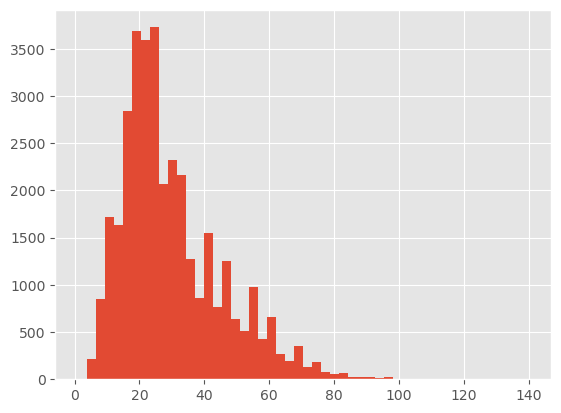

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
words = list(set(dframe["word"].values))
words.append("ENDPAD")

In [13]:
n_words = len(words); n_words

30173

In [14]:
tags = list(set(dframe["tag"].values))
tags

['B-tim',
 'I-art',
 'I-per',
 'I-tim',
 'B-eve',
 'B-geo',
 'O',
 'I-eve',
 'I-org',
 'B-gpe',
 'I-geo',
 nan,
 'I-nat',
 'B-art',
 'B-nat',
 'I-gpe',
 'B-org',
 'B-per']

In [15]:
n_tags = len(tags); n_tags

18

In [16]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [17]:
word2idx['Obama']

22143

In [18]:
tag2idx["O"]

6

In [19]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [21]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [23]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [24]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [25]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [31]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [32]:
model = Model(input, out)

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

704/704 [==============================] - 158s 219ms/step - loss: 0.1243 - accuracy: 0.9748 - val_loss: 0.0485 - val_accuracy: 0.9876


In [35]:
dir = "/home/jovyan/work/data/output/LSTMmodel"
model.save(dir)

2023-05-19 10:57:12.885777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-19 10:57:13.020506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-19 10:57:13.075928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and 

INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


In [36]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

1/1 [==============================] - 0s 308ms/step
Word           (True ): Pred
Mr.           : B-per
Bush          : I-per
's            : O
national      : O
security      : O
advisor       : O
,             : O
Stephen       : B-per
Hadley        : I-per
,             : O
said          : O
Friday        : B-tim
that          : O
if            : O
no            : O
deal          : O
is            : O
reached       : O
before        : O
the           : O
visit         : O
,             : O
negotiations  : O
will          : O
continue      : O
after         : O
the           : O
president     : O
's            : O
trip          : O
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : 

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 140)          4224220   
                                                                 
 dropout (Dropout)           (None, 140, 140)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         192800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 140, 18)          3618      
 ibuted)                                                         
                                                                 
Total params: 4,420,638
Trainable params: 4,420,638
Non-train

In [39]:
# Evaluation
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

220/220 [==============================] - 8s 36ms/step - loss: 0.0490 - accuracy: 0.9876
Loss: 0.0490
Accuracy: 98.76%


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [41]:

y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=-1)

# Flatten the true and predicted labels
y_true_flattened = np.argmax(y_test, axis=-1).flatten()
y_pred_flattened = y_pred_indices.flatten()

# Calculate precision
precision = precision_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate recall
recall = recall_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_true_flattened, y_pred_flattened)

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

220/220 [==============================] - 8s 35ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9855090079707257
Recall: 0.9875913668480468
F1 Score: 0.9862582353593549
Accuracy: 0.9875913668480468
